## Import  libraries 

In [ ]:
import sys, os, glob, time, imageio 
import numpy as np, pandas as pd  

import matplotlib.pyplot as plt 

from PIL import Image 

import torch 
import torchvision.utils as vutils 
import torchvision.transforms as transforms 

from keras import models, layers, optimizers 
from keras.models import Sequential 
from keras.preprocessing.image import array_to_img, img_to_array, load_img 

import tensorflow as tf 


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Paths and lengths 

In [ ]:
# Root directory for dataset
path_root = r'/content/drive/MyDrive/chest_xray/chest_xray'
path_train= r'/content/drive/MyDrive/chest_xray/train'
path_test = r'/content/drive/MyDrive/chest_xray/test'
path_val  = r'/content/drive/MyDrive/chest_xray/val'

# Root paths for X-Ray images
XRay_normal     = glob.glob(path_root+'/*/NORMAL/*.jpeg', recursive=True)
#print(XRay_normal)
XRay_pneumonial = glob.glob(path_root+'/*/PNEUMONIA/*.jpeg', recursive=True)

# Root paths for X-Ray training images
train_normal    = glob.glob(path_train+'NORMAL/*.jpeg', recursive=True)
train_pneumonial= glob.glob(path_train+'PNEUMONIA/*.jpeg', recursive=True)

# X-Ray testing images 
test_normal     = os.listdir(path_test+'/NORMAL/')
test_pneumonial = os.listdir(path_test+'/PNEUMONIA/')

print('The "Chest X-Ray Images" dataset contains {:04d} NORMAL and {:04d} PNEUMONIA images ({:03d} in total)'\
      .format(len(XRay_normal), 
              len(XRay_pneumonial),
              len(glob.glob(path_root+'*/*/*.jpeg')),))
print('   - {:04d} NORMAL and {:04d} PNEUMONIA ==> {:04d} images in the training sample'\
      .format(len(train_normal), 
              len(train_pneumonial), 
              len(glob.glob(path_train+'*/*.jpeg'))))
print('   - {:04d} NORMAL and {:04d} PNEUMONIA ==> {:04d} images in the testing sample'\
      .format(len(test_normal), 
              len(test_pneumonial), 
              len(glob.glob(path_test+'*/*.jpeg'))))
print('   - {:04d} NORMAL and {:04d} PNEUMONIA ==> {:04d} images in the validation sample'\
      .format(len(glob.glob(path_val+'NORMAL/*.jpeg')), 
              len(glob.glob(path_val+'PNEUMONIA/*.jpeg')), 
              len(glob.glob(path_val+'*/*.jpeg'))))

The "Chest X-Ray Images" dataset contains 1583 NORMAL and 4273 PNEUMONIA images (000 in total)
   - 0000 NORMAL and 0000 PNEUMONIA ==> 0000 images in the training sample
   - 0234 NORMAL and 0390 PNEUMONIA ==> 0000 images in the testing sample
   - 0000 NORMAL and 0000 PNEUMONIA ==> 0000 images in the validation sample


## Get data 

In [ ]:
def get_data(data_path, dim=(128, 128), rand_shuffle=True): 
    start = time.time() 
    imgs_data = []         
    sample_size = len(data_path)
    for idx, im_path in enumerate(data_path): 
        if idx%(sample_size//10)==0:
            print('Processing index {:05d} of {:05d} ==> {:03d}%'\
                  .format(idx, sample_size, round(100*idx/sample_size))) 
        img = img_to_array(load_img(im_path, target_size = dim)) 
        imgs_data.append(img) 
        
    # to float 
    imgs_data = np.array(imgs_data).astype('float32') 
    # scale to [0,1] 
    imgs_data = imgs_data/255. 
    
    # shuffle the data 
    if rand_shuffle: 
        idx = np.arange(imgs_data.shape[0])
        np.random.shuffle(idx) 
        
        print('here',np.shape(imgs_data))
        imgs_data = imgs_data[idx] 
    
    print(f"Hey! the calculations are done in {_time(start, time.time())}")
    return imgs_data  


In [ ]:
print('Starting for NORMAL X-Ray images ...')

X_normal = get_data(XRay_normal)
#print(X_normal)
print('Starting for PNEUMONIA X-Ray images ...')
X_pneumonial = get_data(XRay_pneumonial) 

Starting for NORMAL X-Ray images ...
Processing index 00000 of 01583 ==> 000%
Processing index 00158 of 01583 ==> 010%
Processing index 00316 of 01583 ==> 020%
Processing index 00474 of 01583 ==> 030%
Processing index 00632 of 01583 ==> 040%
Processing index 00790 of 01583 ==> 050%
Processing index 00948 of 01583 ==> 060%
Processing index 01106 of 01583 ==> 070%
Processing index 01264 of 01583 ==> 080%
Processing index 01422 of 01583 ==> 090%
Processing index 01580 of 01583 ==> 100%
here (1583, 128, 128, 3)
Hey! the calculations are done in 7min 37.51sec
Starting for PNEUMONIA X-Ray images ...
Processing index 00000 of 04273 ==> 000%
Processing index 00427 of 04273 ==> 010%
Processing index 00854 of 04273 ==> 020%
Processing index 01281 of 04273 ==> 030%
Processing index 01708 of 04273 ==> 040%
Processing index 02135 of 04273 ==> 050%
Processing index 02562 of 04273 ==> 060%
Processing index 02989 of 04273 ==> 070%
Processing index 03416 of 04273 ==> 080%
Processing index 03843 of 0427

In [ ]:
def define_grid(data_images, nrows=4, ncols=5, plot_grid=True):
    # save the started time 
    start = time.time() 
    # Number of GPUs available. Use 0 for CPU mode. 
    ngpu = 1 
    # Decide which device we want to run on 
    device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
    # Rearange the shaphe of the data 
    data_transp = [np.transpose(data_images[i,:,:]) for i in range(data_images[:nrows*ncols].shape[0])]
    # From to torch type for the grid 
    data_transp = torch.Tensor(data_transp)
    print(f'The shape is reordered from {data_images.shape[1:]} to {data_transp.shape[1:]} in {_time(start, time.time())}')
    
    # Make the grid 
    grid_images = np.transpose(
        vutils.make_grid(
            data_transp.to(device)[:nrows*ncols], 
            nrow=nrows,
            padding=2,
            normalize=True,
            scale_each=True,
            pad_value=1,
        ).cpu(), axes=(2,1,0))
        
    # Show the output grid 
    if plot_grid:
        plt.figure(figsize=(12,12)) 
        plt.axis("off") 
        plt.title(f'Grid of {nrows*ncols} real images', fontsize=27)
        plt.imshow(grid_images)
        
    return grid_images

grid_X_normal = define_grid(X_normal, plot_grid=False)
grid_X_pneumonial = define_grid(X_pneumonial, plot_grid=False)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:210.)
  # This is added back by InteractiveShellApp.init_path()


The shape is reordered from (128, 128, 3) to torch.Size([3, 128, 128]) in 0.25sec
The shape is reordered from (128, 128, 3) to torch.Size([3, 128, 128]) in 0.07sec


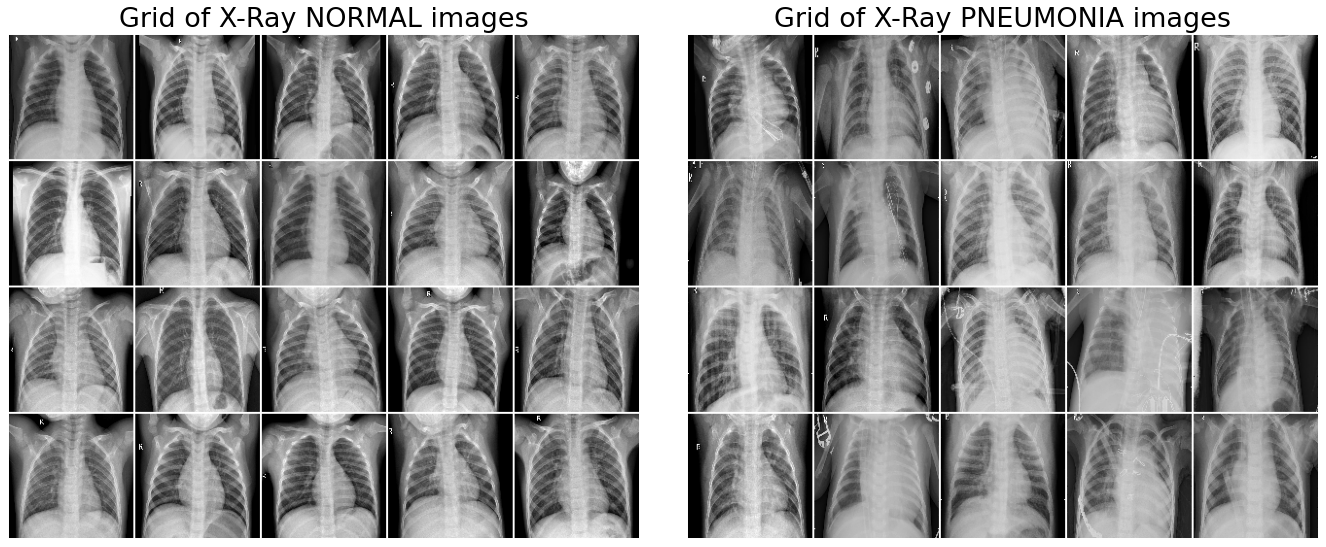

In [ ]:
fig, (ax1, ax2)= plt.subplots(nrows=1, ncols=2, figsize=(19, 8))

ax1.imshow(grid_X_normal); ax1.axis('off')
ax1.set_title(label = 'Grid of X-Ray NORMAL images', fontsize = 27)

ax2.imshow(grid_X_pneumonial); ax2.axis('off')
ax2.set_title(label = 'Grid of X-Ray PNEUMONIA images', fontsize = 27)

plt.tight_layout(pad=1.08, h_pad=None, w_pad=None, rect=[0, 0.03, 1, 0.95])

## Set the parameters  

In [ ]:


# Number of training epochs
n_epoch = 200 

# Batch size during training 
batch_size = 128 

# Size of z latent vector
latent_dim = 100 

# Spatial size of training images.
cols, rows = 128, 128 

# Number of channels 
channels = 3 
dim = cols, rows # height, width 
in_shape = (cols, rows, channels) # height, width, color 

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1 

# plot ncols images in row and nrows images in colomn
nrows, ncols = 3, 4


# Discriminator 

In [ ]:
def define_discriminator(in_shape=(128,128,3)): 
    model = models.Sequential() 
    # normal 
    model.add(layers.Conv2D(128, (5,5), padding='same', input_shape=in_shape)) 
    model.add(layers.LeakyReLU(alpha=0.2)) 
    # downsample to 64x64 
    model.add(layers.Conv2D(128, (5,5), strides=(2,2), padding='same')) 
    model.add(layers.LeakyReLU(alpha=0.2)) 
    # downsample to 32x32 
    model.add(layers.Conv2D(128, (5,5), strides=(2,2), padding='same')) 
    model.add(layers.LeakyReLU(alpha=0.2)) 
    # downsample to 16x16 
    model.add(layers.Conv2D(128, (5,5), strides=(2,2), padding='same')) 
    model.add(layers.LeakyReLU(alpha=0.2)) 
    # downsample to 8x8 
    model.add(layers.Conv2D(128, (5,5), strides=(2,2), padding='same')) 
    model.add(layers.LeakyReLU(alpha=0.2)) 
    # classifier 
    model.add(layers.Flatten()) 
    model.add(layers.Dropout(0.4)) 
    model.add(layers.Dense(1, activation='sigmoid')) 
    # compile model 
    opt = tf.optimizers.Adam(lr=0.0002, beta_1=0.5) 
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy']) 
    return model

## Generator 

In [ ]:
def define_generator(latent_dim):
    model = models.Sequential()
    # foundation for 8x8 feature maps
    n_nodes = 128*8*8
    model.add(layers.Dense(n_nodes, input_dim=latent_dim))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Reshape((8, 8, 128)))
    # upsample to 16x16
    model.add(layers.Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    # upsample to 32x32
    model.add(layers.Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    # upsample to 64x64
    model.add(layers.Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    # upsample to 128x128
    model.add(layers.Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    # output layer 128x128x3
    model.add(layers.Conv2D(3, (5,5), activation='tanh', padding='same'))
    return model 

#input of G
def generate_latent_points(latent_dim, n_samples):
    # generate points in the latent space
    x_input = np.random.randn(latent_dim*n_samples)
    # reshape into a batch of inputs for the network
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input 

# use the generator to generate n fake examples, with class labels
def generate_fake_samples(g_model, latent_dim, n_samples):
    # generate points in latent space
    x_input = generate_latent_points(latent_dim, n_samples)
    # predict outputs
    X = g_model.predict(x_input)
    # create 'fake' class labels (0)
    y = np.zeros((n_samples, 1))
    return X, y

## Define GAN model 

In [ ]:
def define_gan(g_model, d_model): 
    # make weights in the discriminator not trainable
    d_model.trainable = False 
    # connect them
    model = models.Sequential()
    # add generator
    model.add(g_model)
    # add the discriminator
    model.add(d_model)
    # compile model
    opt = tf.optimizers.Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model

# retrive real samples
def get_real_samples(dataset, n_samples):
    # choose random instances
    ix = np.random.randint(0, dataset.shape[0], n_samples)
    # retrieve selected images
    X = dataset[ix]
    # set 'real' class labels (1)
    y = np.ones((n_samples, 1))
    return X, y

# create and save a plot of generated images 
def show_generated(generated, epoch, nrows=4, ncols=5):
    #[-1,1] -> [0,1] 
    #generated = (generated+1)/2 
    #generated = (generated[:ncols*nrows]*127.5)+127.5 
    #generated = generated*255 
    plt.figure(figsize=(10,10)) 
    for idx in range(nrows*ncols): 
        plt.subplot(nrows, ncols, idx+1) 
        plt.imshow(generated[idx]) 
        plt.axis('off') 
    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch+1)) 
    plt.show() 

# evaluate the discriminator and plot generated images 
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=100):
    # prepare real samples
    X_real, y_real = get_real_samples(dataset, n_samples)
    # evaluate discriminator on real examples 
    _, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
    # prepare fake examples 
    x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
    # evaluate discriminator on fake examples 
    _, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
    # summarize discriminator performance 
    print('> Accuracy at epoch %d [real: %.0f%%, fake: %.0f%%]'%(epoch+1, acc_real*100, acc_fake*100))
    # show plot 
    show_generated(x_fake, epoch)  
    
def plot_loss(loss):
    plt.figure(figsize=(10,5))
    plt.title("Generator and Discriminator Loss During Training", fontsize=20) 
    plt.plot(loss[0], label="D_real") 
    plt.plot(loss[1], label="D_fake") 
    plt.plot(loss[2], label="G") 
    plt.xlabel("Iteration", fontsize=20); plt.ylabel("Loss", fontsize=20) 
    plt.legend(); plt.show() 

# Train the models 

In [ ]:
def train(g_model, d_model, gan_model, dataset, latent_dim=100, n_epochs=100, n_batch=128):
    
    start = time.time() 
    bat_per_epo = int(dataset.shape[0]/n_batch) 
    half_batch = int(n_batch/2) 
    loss1, loss2, loss3 = [], [], [] 
    fake_liste = [] 
    
    # manually enumerate epochs
    print('Training Start...')
    for i in range(n_epochs):
        start1 = time.time()
        # enumerate batches over the training set
        for j in range(bat_per_epo):
            # get randomly selected 'real' samples
            X_real, y_real = get_real_samples(dataset, half_batch)
            # update discriminator model weights
            d_loss1, _ = d_model.train_on_batch(X_real, y_real)
            # generate 'fake' examples
            X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
            # update discriminator model weights
            d_loss2, _ = d_model.train_on_batch(X_fake, y_fake)
            # prepare points in latent space as input for the generator
            X_gan = generate_latent_points(latent_dim, n_batch)
            # create inverted labels for the fake samples
            y_gan = np.ones((n_batch, 1))
            # update the generator via the discriminator's error
            g_loss = gan_model.train_on_batch(X_gan, y_gan)
            # summarize loss on this batch
            loss1.append(d_loss1); loss2.append(d_loss2); loss3.append(g_loss) 
        
        print('Epoch: {:03d}/{:03d}, Loss: [D_real = {:2.3f}, D_fake = {:2.3f}, G = {:2.3f}], time: {:s}'\
              .format(i+1,n_epochs,d_loss1,d_loss2,g_loss, _time(start1,time.time())))
        # evaluate the model performance 
        if (i+1)%(n_epochs//10) == 0: 
            # Save and show generated images 
            summarize_performance(i, g_model, d_model, dataset, latent_dim) 
        
    print('Total time for training {} epochs is {} sec'.format(n_epochs, _time(start, time.time())))
    
    # Show loss curves 
    loss = (loss1, loss2, loss3) 
    plot_loss(loss) 

In [ ]:
discriminator = define_discriminator() 
generator = define_generator(latent_dim) 

# create the gan 
gan = define_gan(generator, discriminator)


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Training Start...
Epoch: 001/200, Loss: [D_real = 0.344, D_fake = 0.669, G = 1.043], time: 45.69sec
Epoch: 002/200, Loss: [D_real = 0.011, D_fake = 0.005, G = 6.396], time: 19.49sec
Epoch: 003/200, Loss: [D_real = 0.000, D_fake = 0.763, G = 0.685], time: 19.3sec
Epoch: 004/200, Loss: [D_real = 0.000, D_fake = 1.787, G = 0.842], time: 20.06sec
Epoch: 005/200, Loss: [D_real = 0.054, D_fake = 0.737, G = 0.789], time: 20.56sec
Epoch: 006/200, Loss: [D_real = 0.136, D_fake = 0.812, G = 0.681], time: 20.45sec
Epoch: 007/200, Loss: [D_real = 0.286, D_fake = 0.697, G = 1.080], time: 20.12sec
Epoch: 008/200, Loss: [D_real = 0.451, D_fake = 0.614, G = 1.348], time: 20.01sec
Epoch: 009/200, Loss: [D_real = 0.736, D_fake = 0.763, G = 0.865], time: 20.05sec
Epoch: 010/200, Loss: [D_real = 0.704, D_fake = 0.686, G = 0.848], time: 20.94sec
Epoch: 011/200, Loss: [D_real = 0.711, D_fake = 0.654, G = 0.829], time: 20.24sec
Epoch: 012/200, Loss: [D_real = 0.705, D_fake = 0.657, G = 0.850], time: 20.14sec

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


> Accuracy at epoch 20 [real: 81%, fake: 99%]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

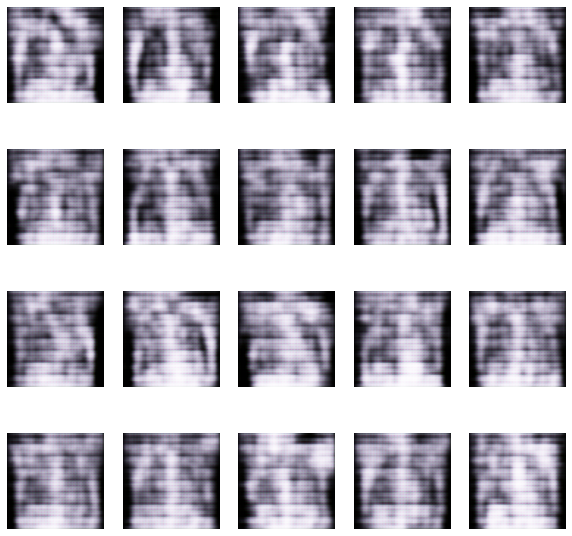

Epoch: 021/200, Loss: [D_real = 0.674, D_fake = 0.620, G = 1.112], time: 20.26sec
Epoch: 022/200, Loss: [D_real = 0.621, D_fake = 0.553, G = 1.242], time: 20.18sec
Epoch: 023/200, Loss: [D_real = 0.714, D_fake = 0.615, G = 0.901], time: 20.26sec
Epoch: 024/200, Loss: [D_real = 0.539, D_fake = 0.667, G = 1.003], time: 20.24sec
Epoch: 025/200, Loss: [D_real = 0.633, D_fake = 0.681, G = 0.882], time: 20.16sec
Epoch: 026/200, Loss: [D_real = 0.667, D_fake = 0.663, G = 1.152], time: 20.23sec
Epoch: 027/200, Loss: [D_real = 0.640, D_fake = 0.605, G = 1.183], time: 20.16sec
Epoch: 028/200, Loss: [D_real = 0.541, D_fake = 0.537, G = 1.275], time: 20.28sec
Epoch: 029/200, Loss: [D_real = 0.559, D_fake = 0.564, G = 1.035], time: 20.2sec
Epoch: 030/200, Loss: [D_real = 0.537, D_fake = 0.439, G = 1.404], time: 20.16sec
Epoch: 031/200, Loss: [D_real = 0.449, D_fake = 0.600, G = 1.408], time: 20.2sec
Epoch: 032/200, Loss: [D_real = 0.411, D_fake = 0.543, G = 1.814], time: 20.17sec
Epoch: 033/200, Lo

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

> Accuracy at epoch 40 [real: 82%, fake: 98%]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


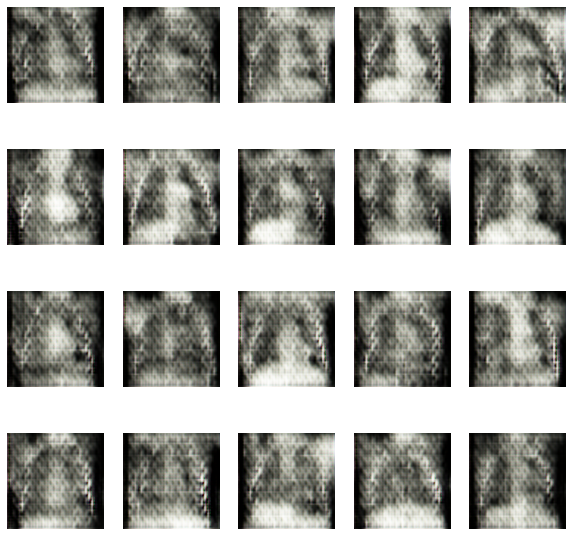

Epoch: 041/200, Loss: [D_real = 0.463, D_fake = 0.384, G = 2.863], time: 20.93sec
Epoch: 042/200, Loss: [D_real = 0.699, D_fake = 0.523, G = 1.562], time: 20.23sec
Epoch: 043/200, Loss: [D_real = 0.394, D_fake = 0.533, G = 2.163], time: 20.3sec
Epoch: 044/200, Loss: [D_real = 0.323, D_fake = 0.338, G = 2.543], time: 20.23sec
Epoch: 045/200, Loss: [D_real = 0.248, D_fake = 0.433, G = 2.801], time: 20.52sec
Epoch: 046/200, Loss: [D_real = 0.583, D_fake = 0.458, G = 2.170], time: 20.13sec
Epoch: 047/200, Loss: [D_real = 0.349, D_fake = 0.388, G = 2.287], time: 20.9sec
Epoch: 048/200, Loss: [D_real = 0.539, D_fake = 0.474, G = 2.150], time: 20.18sec
Epoch: 049/200, Loss: [D_real = 0.412, D_fake = 0.348, G = 2.213], time: 20.22sec
Epoch: 050/200, Loss: [D_real = 0.477, D_fake = 0.403, G = 2.880], time: 20.27sec
Epoch: 051/200, Loss: [D_real = 0.294, D_fake = 0.328, G = 2.976], time: 20.3sec
Epoch: 052/200, Loss: [D_real = 0.383, D_fake = 0.364, G = 2.448], time: 20.21sec
Epoch: 053/200, Los

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


> Accuracy at epoch 60 [real: 85%, fake: 100%]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

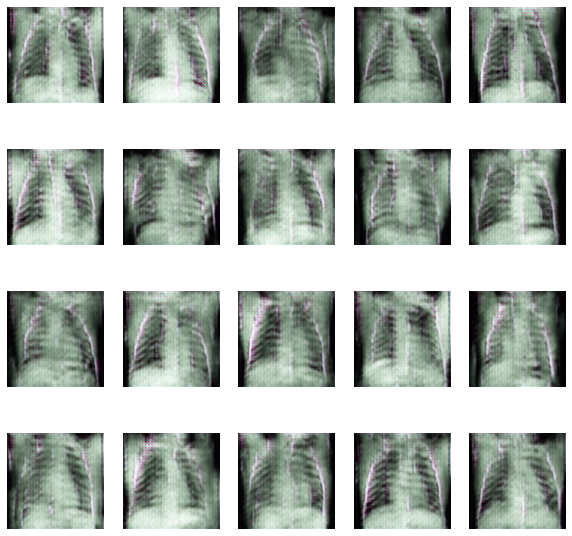

Epoch: 061/200, Loss: [D_real = 0.229, D_fake = 0.262, G = 3.056], time: 20.18sec
Epoch: 062/200, Loss: [D_real = 0.499, D_fake = 0.353, G = 2.533], time: 20.23sec
Epoch: 063/200, Loss: [D_real = 0.940, D_fake = 0.450, G = 2.784], time: 20.23sec
Epoch: 064/200, Loss: [D_real = 0.643, D_fake = 0.468, G = 2.681], time: 20.22sec
Epoch: 065/200, Loss: [D_real = 0.646, D_fake = 0.415, G = 2.202], time: 20.23sec
Epoch: 066/200, Loss: [D_real = 0.552, D_fake = 0.401, G = 2.347], time: 20.2sec
Epoch: 067/200, Loss: [D_real = 0.386, D_fake = 0.389, G = 2.752], time: 20.53sec
Epoch: 068/200, Loss: [D_real = 0.443, D_fake = 0.404, G = 3.007], time: 20.14sec
Epoch: 069/200, Loss: [D_real = 0.322, D_fake = 0.295, G = 2.419], time: 20.18sec
Epoch: 070/200, Loss: [D_real = 0.336, D_fake = 0.392, G = 3.587], time: 20.3sec
Epoch: 071/200, Loss: [D_real = 0.326, D_fake = 0.393, G = 2.750], time: 20.18sec
Epoch: 072/200, Loss: [D_real = 0.484, D_fake = 0.513, G = 2.444], time: 20.25sec
Epoch: 073/200, Lo

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

> Accuracy at epoch 80 [real: 78%, fake: 99%]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

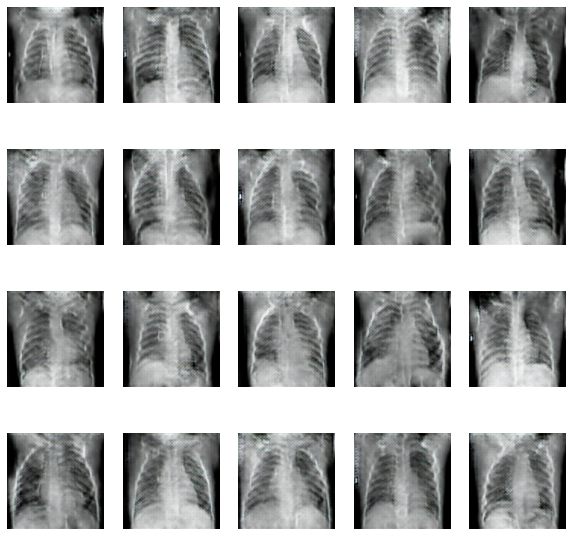

Epoch: 081/200, Loss: [D_real = 0.342, D_fake = 0.286, G = 2.985], time: 20.19sec
Epoch: 082/200, Loss: [D_real = 0.501, D_fake = 0.333, G = 2.466], time: 20.2sec
Epoch: 083/200, Loss: [D_real = 0.551, D_fake = 0.368, G = 2.145], time: 20.25sec
Epoch: 084/200, Loss: [D_real = 0.383, D_fake = 0.513, G = 2.585], time: 20.51sec
Epoch: 085/200, Loss: [D_real = 0.456, D_fake = 0.466, G = 2.949], time: 20.21sec
Epoch: 086/200, Loss: [D_real = 0.456, D_fake = 0.492, G = 2.366], time: 20.24sec
Epoch: 087/200, Loss: [D_real = 0.503, D_fake = 0.402, G = 2.528], time: 20.21sec
Epoch: 088/200, Loss: [D_real = 0.460, D_fake = 0.587, G = 2.176], time: 20.23sec
Epoch: 089/200, Loss: [D_real = 0.367, D_fake = 0.273, G = 2.381], time: 20.25sec
Epoch: 090/200, Loss: [D_real = 0.478, D_fake = 0.595, G = 2.867], time: 20.26sec
Epoch: 091/200, Loss: [D_real = 0.571, D_fake = 0.414, G = 2.221], time: 20.18sec
Epoch: 092/200, Loss: [D_real = 0.428, D_fake = 0.379, G = 2.680], time: 20.49sec
Epoch: 093/200, L

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

> Accuracy at epoch 100 [real: 84%, fake: 100%]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


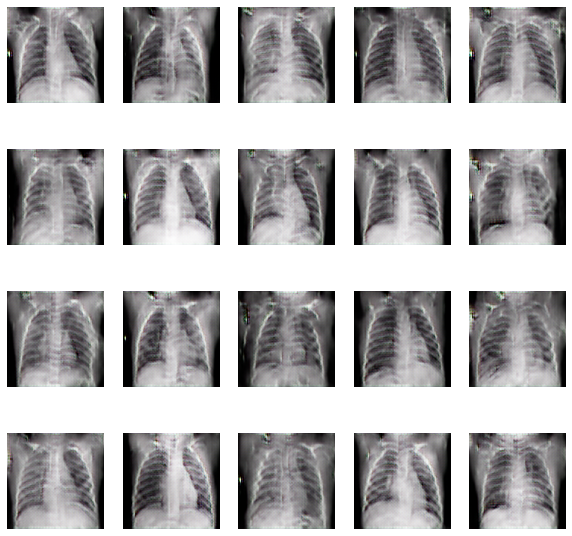

Epoch: 101/200, Loss: [D_real = 0.336, D_fake = 0.499, G = 2.901], time: 20.18sec
Epoch: 102/200, Loss: [D_real = 0.561, D_fake = 0.498, G = 2.273], time: 20.11sec
Epoch: 103/200, Loss: [D_real = 0.305, D_fake = 0.363, G = 2.802], time: 20.8sec
Epoch: 104/200, Loss: [D_real = 0.432, D_fake = 0.409, G = 2.516], time: 20.14sec
Epoch: 105/200, Loss: [D_real = 0.647, D_fake = 0.915, G = 2.512], time: 20.15sec
Epoch: 106/200, Loss: [D_real = 0.518, D_fake = 0.391, G = 2.325], time: 20.22sec
Epoch: 107/200, Loss: [D_real = 0.285, D_fake = 0.328, G = 2.807], time: 20.24sec
Epoch: 108/200, Loss: [D_real = 0.424, D_fake = 0.357, G = 2.435], time: 20.17sec
Epoch: 109/200, Loss: [D_real = 0.420, D_fake = 0.330, G = 2.997], time: 20.22sec
Epoch: 110/200, Loss: [D_real = 0.560, D_fake = 0.744, G = 2.014], time: 20.16sec
Epoch: 111/200, Loss: [D_real = 0.572, D_fake = 0.526, G = 2.680], time: 20.15sec
Epoch: 112/200, Loss: [D_real = 0.361, D_fake = 0.448, G = 2.768], time: 20.22sec
Epoch: 113/200, L

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

> Accuracy at epoch 120 [real: 84%, fake: 100%]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

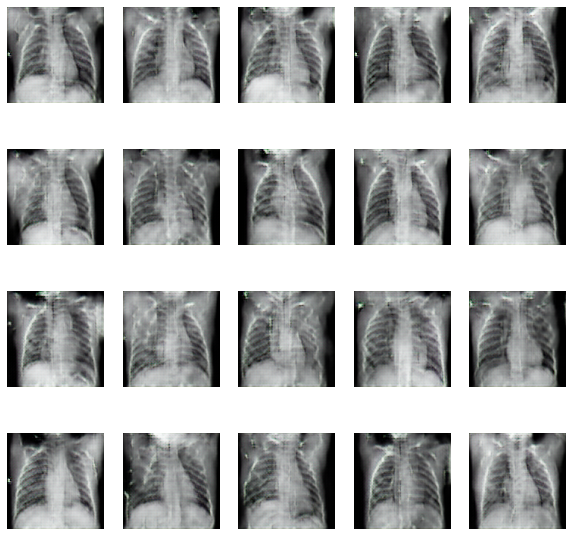

Epoch: 121/200, Loss: [D_real = 0.418, D_fake = 0.319, G = 1.582], time: 20.36sec
Epoch: 122/200, Loss: [D_real = 0.363, D_fake = 0.406, G = 2.050], time: 20.15sec
Epoch: 123/200, Loss: [D_real = 0.266, D_fake = 0.326, G = 2.649], time: 20.17sec
Epoch: 124/200, Loss: [D_real = 0.396, D_fake = 0.269, G = 2.780], time: 20.17sec
Epoch: 125/200, Loss: [D_real = 0.436, D_fake = 0.511, G = 2.244], time: 20.14sec
Epoch: 126/200, Loss: [D_real = 0.391, D_fake = 0.333, G = 2.314], time: 20.1sec
Epoch: 127/200, Loss: [D_real = 0.412, D_fake = 0.440, G = 2.535], time: 20.11sec
Epoch: 128/200, Loss: [D_real = 0.377, D_fake = 0.347, G = 2.265], time: 20.15sec
Epoch: 129/200, Loss: [D_real = 0.421, D_fake = 0.460, G = 2.765], time: 20.11sec
Epoch: 130/200, Loss: [D_real = 0.317, D_fake = 0.326, G = 2.743], time: 20.12sec
Epoch: 131/200, Loss: [D_real = 0.262, D_fake = 0.424, G = 2.531], time: 20.13sec
Epoch: 132/200, Loss: [D_real = 0.401, D_fake = 0.219, G = 2.510], time: 20.27sec
Epoch: 133/200, L

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

> Accuracy at epoch 140 [real: 76%, fake: 100%]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

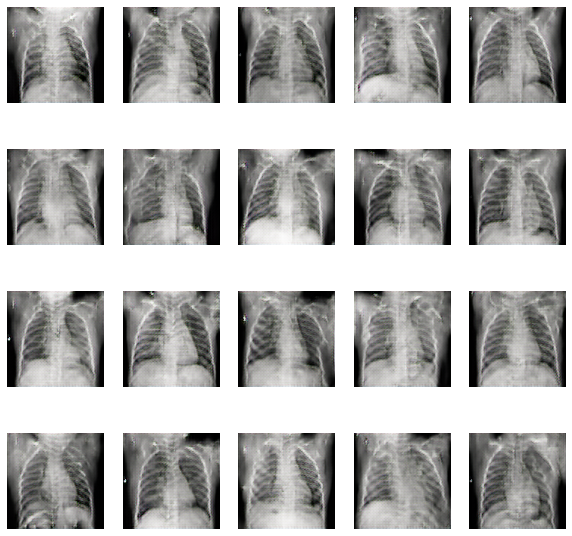

Epoch: 141/200, Loss: [D_real = 0.307, D_fake = 0.340, G = 2.799], time: 20.12sec
Epoch: 142/200, Loss: [D_real = 0.203, D_fake = 0.204, G = 3.365], time: 20.15sec
Epoch: 143/200, Loss: [D_real = 1.732, D_fake = 0.357, G = 1.512], time: 20.17sec
Epoch: 144/200, Loss: [D_real = 0.249, D_fake = 0.361, G = 2.227], time: 20.25sec
Epoch: 145/200, Loss: [D_real = 0.367, D_fake = 0.251, G = 3.208], time: 20.34sec
Epoch: 146/200, Loss: [D_real = 0.296, D_fake = 0.302, G = 2.430], time: 20.2sec
Epoch: 147/200, Loss: [D_real = 0.329, D_fake = 0.260, G = 2.591], time: 20.15sec
Epoch: 148/200, Loss: [D_real = 0.578, D_fake = 0.773, G = 1.401], time: 20.23sec
Epoch: 149/200, Loss: [D_real = 0.417, D_fake = 0.426, G = 1.772], time: 20.1sec
Epoch: 150/200, Loss: [D_real = 0.321, D_fake = 0.257, G = 2.269], time: 20.16sec
Epoch: 151/200, Loss: [D_real = 0.235, D_fake = 0.386, G = 2.768], time: 20.16sec
Epoch: 152/200, Loss: [D_real = 0.282, D_fake = 0.210, G = 2.841], time: 20.39sec
Epoch: 153/200, Lo

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

> Accuracy at epoch 160 [real: 93%, fake: 100%]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

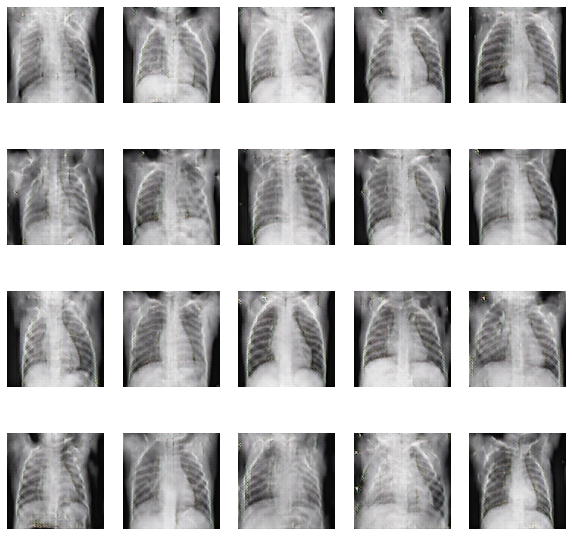

Epoch: 161/200, Loss: [D_real = 0.371, D_fake = 0.273, G = 2.649], time: 20.11sec
Epoch: 162/200, Loss: [D_real = 0.437, D_fake = 0.145, G = 2.875], time: 20.23sec
Epoch: 163/200, Loss: [D_real = 0.221, D_fake = 0.151, G = 3.430], time: 20.2sec
Epoch: 164/200, Loss: [D_real = 0.359, D_fake = 0.197, G = 2.802], time: 20.12sec
Epoch: 165/200, Loss: [D_real = 0.168, D_fake = 0.101, G = 3.980], time: 20.8sec
Epoch: 166/200, Loss: [D_real = 0.284, D_fake = 0.198, G = 3.391], time: 20.09sec
Epoch: 167/200, Loss: [D_real = 0.336, D_fake = 0.166, G = 3.441], time: 20.19sec
Epoch: 168/200, Loss: [D_real = 0.152, D_fake = 0.106, G = 3.441], time: 20.22sec
Epoch: 169/200, Loss: [D_real = 0.266, D_fake = 0.100, G = 3.378], time: 20.23sec
Epoch: 170/200, Loss: [D_real = 0.117, D_fake = 0.301, G = 4.318], time: 20.65sec
Epoch: 171/200, Loss: [D_real = 0.203, D_fake = 0.188, G = 3.984], time: 20.17sec
Epoch: 172/200, Loss: [D_real = 0.502, D_fake = 0.309, G = 3.494], time: 20.12sec
Epoch: 173/200, Lo

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

> Accuracy at epoch 180 [real: 89%, fake: 99%]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


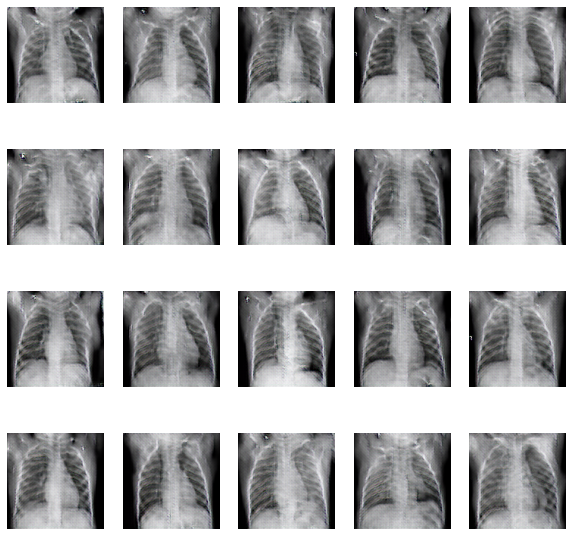

Epoch: 181/200, Loss: [D_real = 0.210, D_fake = 0.157, G = 4.047], time: 20.17sec
Epoch: 182/200, Loss: [D_real = 0.172, D_fake = 0.091, G = 3.134], time: 20.22sec
Epoch: 183/200, Loss: [D_real = 0.432, D_fake = 0.158, G = 2.963], time: 20.16sec
Epoch: 184/200, Loss: [D_real = 0.109, D_fake = 0.165, G = 3.908], time: 20.16sec
Epoch: 185/200, Loss: [D_real = 0.165, D_fake = 0.139, G = 4.075], time: 20.28sec
Epoch: 186/200, Loss: [D_real = 0.350, D_fake = 0.490, G = 4.301], time: 20.17sec
Epoch: 187/200, Loss: [D_real = 0.075, D_fake = 0.133, G = 4.456], time: 20.11sec
Epoch: 188/200, Loss: [D_real = 0.397, D_fake = 0.234, G = 2.890], time: 20.11sec
Epoch: 189/200, Loss: [D_real = 0.246, D_fake = 0.279, G = 2.691], time: 20.12sec
Epoch: 190/200, Loss: [D_real = 0.045, D_fake = 0.140, G = 3.355], time: 20.18sec
Epoch: 191/200, Loss: [D_real = 0.255, D_fake = 0.097, G = 3.268], time: 20.15sec
Epoch: 192/200, Loss: [D_real = 0.139, D_fake = 0.211, G = 3.500], time: 20.25sec
Epoch: 193/200, 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

> Accuracy at epoch 200 [real: 95%, fake: 97%]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

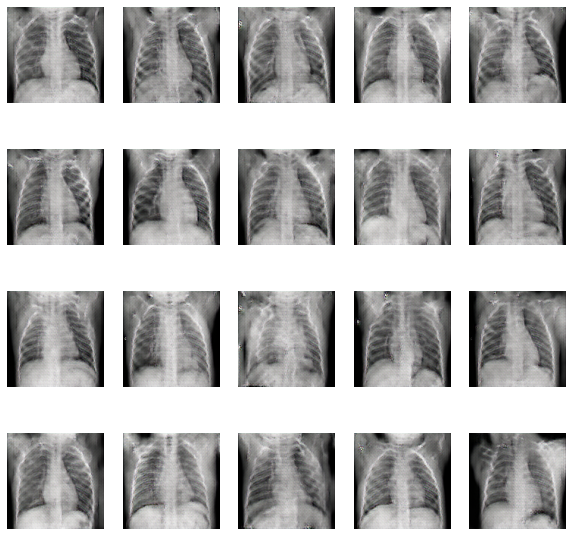

Total time for training 200 epochs is 1h 8min 14.14sec sec


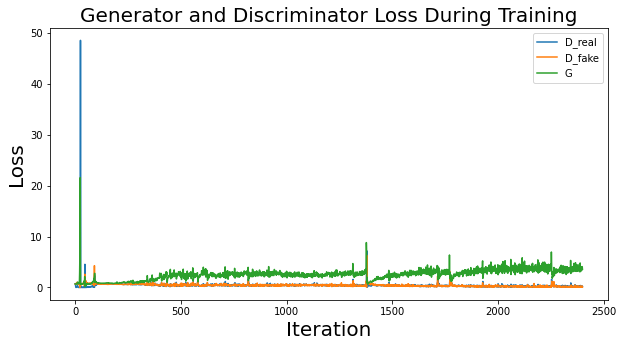

In [ ]:
# train model 
train(generator, discriminator, gan, X_normal, latent_dim, n_epochs=n_epoch, n_batch=batch_size)

## Generated and save the images in a zippez file 

In [ ]:
# use the generator to generate n fake
def XRayFakeGenerator(g_model=generator, latent_dim =100, n_samples=100, show_gen=False):
    # generate points in latent space 
    x_input = generate_latent_points(latent_dim, n_samples)
    # predict outputs 
    X = g_model.predict(x_input)  
    
    # Show the generated images
    if show_gen and n_samples<=30: 
        ncols = 5
        nrows = int(n_samples/ncols)
        plt.figure(figsize=(12,10)) 
        for idx in range(nrows*ncols): 
            plt.subplot(nrows, ncols, idx+1)
            plt.imshow(X[idx,:,:]); plt.axis('off')
        plt.show();
    return X 

XRay_fake = XRayFakeGenerator(generator, n_samples=20)

In [ ]:
# SAVE TO ZIP FILE 
import zipfile
output_path = zipfile.PyZipFile('/content/drive/MyDrive/outzip/XRayNormalFake.zip', mode='w')

XRay_generated = XRayFakeGenerator(n_samples=1000)
for idx in range(XRay_generated.shape[0]):
    img_XRayFake  = XRay_generated[idx,:,:]
    name_XRayFake = 'XRay_generated {:04d}.png'.format(idx)
    imageio.imwrite(name_XRayFake, img_XRayFake)
    
    output_path.write(name_XRayFake)
    os.remove(name_XRayFake) 
output_path.close()